**Name: Anurag Shukla**

**202318039**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c89c17bbe56f223788f6d856f97c2ed5c15b0f65a44536818e246f87e1c3e46d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from sklearn.datasets import fetch_20newsgroups

# Fetching the 20 newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

# Printing the target names (categories)
print("Categories:", newsgroups_data.target_names)

# Printing the first few lines of the first document
print("\nSample Document:")
print(newsgroups_data.data[0][:500])  # Printing first 500 characters of the first document


Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Sample Document:
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killin


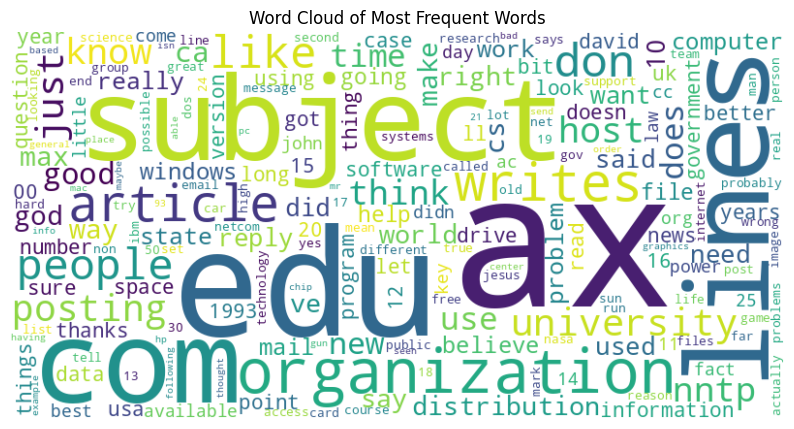

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer to compute word frequencies
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
word_counts = count_vectorizer.fit_transform(newsgroups_data.data)

# Obtain feature names (words)
feature_names = count_vectorizer.get_feature_names_out()

# Compute word frequencies
word_freq = dict(zip(feature_names, np.asarray(word_counts.sum(axis=0)).ravel()))

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


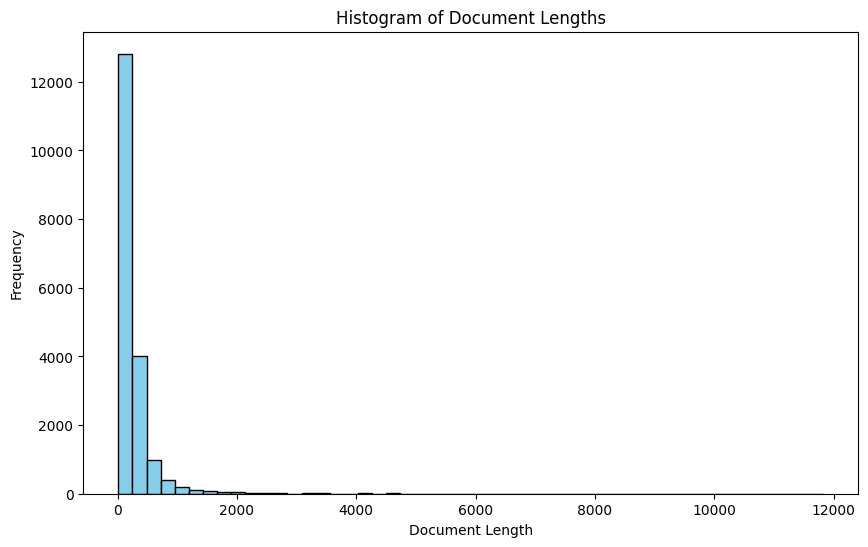

In [10]:
# Plot histogram of document lengths
document_lengths = [len(doc.split()) for doc in newsgroups_data.data]
plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

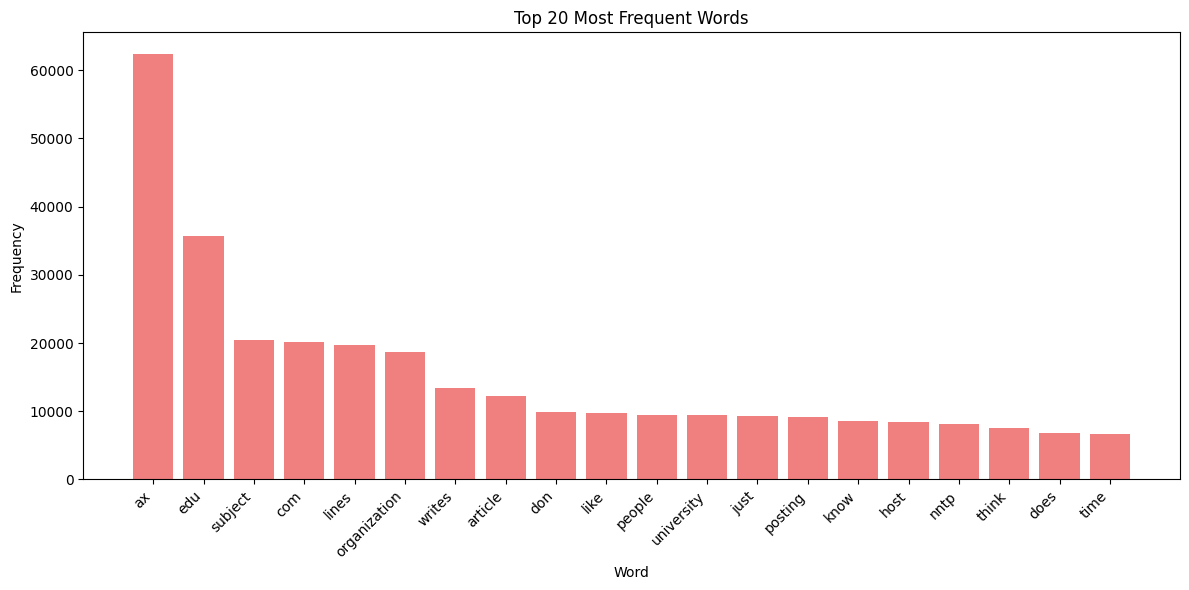

In [12]:
# Plot bar plot of word frequencies
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]  # Top 20 words
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in sorted_word_freq], [word[1] for word in sorted_word_freq], color='lightcoral')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


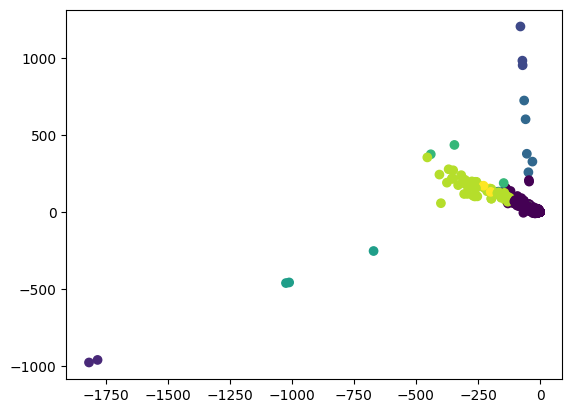

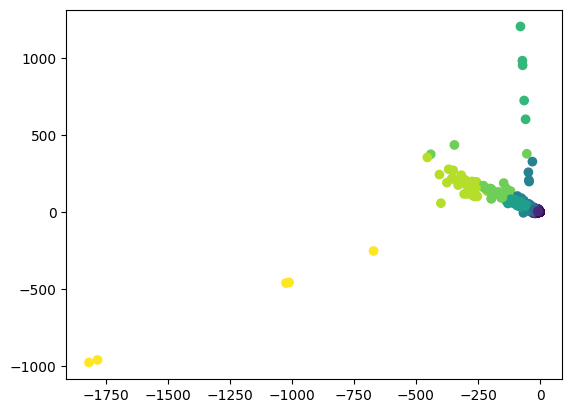

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("20 Newsgroups Clustering") \
    .getOrCreate()

# Step 2: Load and preprocess the dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(data)

# Feature extraction using TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Step 3: Apply K-means clustering
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(rescaledData)
predictions = model.transform(rescaledData)

# Step 4: Visualize K-means clusters
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(rescaledData)
transformed = model.transform(rescaledData)
pandas_df = transformed.select('pcaFeatures').toPandas()

plt.scatter(pandas_df['pcaFeatures'].apply(lambda x: x[0]), pandas_df['pcaFeatures'].apply(lambda x: x[1]), c=predictions.select('prediction').toPandas()['prediction'])
plt.show()

# Step 5: Apply Hierarchical clustering (Bisecting K-means)
bkm = BisectingKMeans().setK(10).setSeed(1)
model_bkm = bkm.fit(rescaledData)
predictions_bkm = model_bkm.transform(rescaledData)


# Step 6: Visualize Hierarchical clusters
pandas_df_bkm = transformed.select('pcaFeatures').toPandas()

plt.scatter(pandas_df_bkm['pcaFeatures'].apply(lambda x: x[0]), pandas_df_bkm['pcaFeatures'].apply(lambda x: x[1]), c=predictions_bkm.select('prediction').toPandas()['prediction'])
plt.show()

# Step 7: Stop SparkSession
spark.stop()


**• Perform K-means clustering and Hierarchical clustering upon the dataset
fetch 20 newsgroups link using PySpark**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Document Clustering") \
    .getOrCreate()

# Load dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
data_words = tokenizer.transform(data)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data_filtered = remover.transform(data_words)

# Calculate TF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=1000)
tf_data = hashingTF.transform(data_filtered)

# Calculate IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(tf_data)
tfidf_data = idf_model.transform(tf_data)

# K-Means Clustering
kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=5)
kmeans_model = kmeans.fit(tfidf_data)
kmeans_predictions = kmeans_model.transform(tfidf_data)

# Hierarchical Clustering
hierarchical = BisectingKMeans(featuresCol="features", predictionCol="prediction", k=5)
hierarchical_model = hierarchical.fit(tfidf_data)
hierarchical_predictions = hierarchical_model.transform(tfidf_data)

# Evaluate clustering results
evaluator = ClusteringEvaluator()
silhouette_kmeans = evaluator.evaluate(kmeans_predictions)
silhouette_hierarchical = evaluator.evaluate(hierarchical_predictions)
print("Silhouette Score (K-Means):", silhouette_kmeans)
print("Silhouette Score (Hierarchical):", silhouette_hierarchical)


# Stop SparkSession
spark.stop()


Silhouette Score (K-Means): 0.9962802182165482
Silhouette Score (Hierarchical): 0.47242240329383584


The silhouette score for K-Means is approximately 0.996, which is very close to 1, indicating that the clusters generated by K-Means are well-separated.

The silhouette score for Hierarchical clustering is approximately 0.472, which is lower compared to K-Means. It suggests that the clusters generated by Hierarchical clustering might have some overlap or are not as well-separated as those from K-Means.

**Represent each document using TfIdf matrix.**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np

# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("20 Newsgroups TF-IDF") \
    .getOrCreate()

# Step 2: Load and preprocess the dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(data)

# Feature extraction using TF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)

# Compute IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
tfidfData = idfModel.transform(featurizedData)

# Extracting TF-IDF matrix as a dense vector
extract_dense_vector = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))
tfidf_dense = tfidfData.withColumn("tfidf_dense", extract_dense_vector("features")).select("tfidf_dense")

# Convert to numpy array
tfidf_matrix = np.array(tfidf_dense.collect())

# Print the TF-IDF matrix
print("TF-IDF Matrix:")
print(tfidf_matrix)

# Step 3: Stop SparkSession
spark.stop()


TF-IDF Matrix:
[[[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         1.89572374 ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 ...

 [[0.         0.         0.         ... 0.         2.23971268 0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         2.55041131 0.         ... 0.         0.         0.        ]]]


**Finding the optimal number of clusters (K) using the Elbow method**

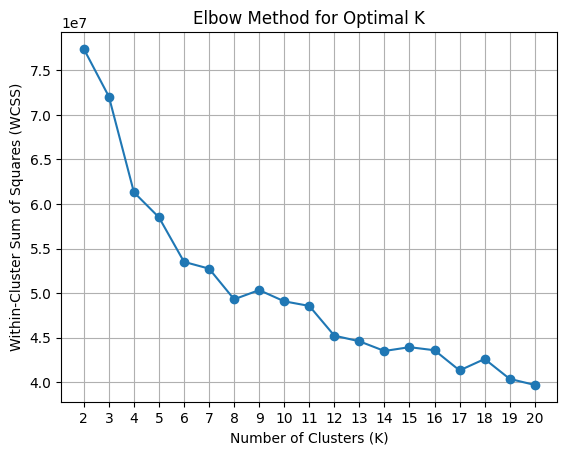

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("20 Newsgroups Clustering") \
    .getOrCreate()

# Step 2: Load and preprocess the dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(data)

# Feature extraction using TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Step 3: Find the optimal number of clusters (K) using the Elbow method
wcss_values = []
k_values = range(2, 21)  # K values from 2 to 20

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(rescaledData)
    centroids = model.clusterCenters()
    cluster_assignments = model.transform(rescaledData).select('prediction').collect()
    wcss = sum(np.linalg.norm(np.array(row.features) - centroids[prediction.prediction]) ** 2 for row, prediction in zip(rescaledData.collect(), cluster_assignments))
    wcss_values.append(wcss)

# Step 4: Plot the WCSS values for different K values
plt.plot(k_values, wcss_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


# Step 5: Stop SparkSession
spark.stop()


Observations


---



Based on the elbow method plot above, the optimal number of clusters would be 3.

Here's how we can interpret the elbow method plot:

X-axis: The X-axis represents the number of clusters (k).

Y-axis: The Y-axis represents the Within-Cluster Sum of Squares (WCSS). This metric measures the total squared distance of each data point to its cluster center (centroid).

Elbow Shape: The ideal elbow method plot shows a sharp decrease in WCSS as the number of clusters increases, followed by a more gradual decrease (the "elbow"). The number of clusters corresponding to the elbow is considered the optimal choice because it balances minimizing WCSS (good clustering) with avoiding overfitting (too many clusters).

In the above plot, there's a clear decrease in WCSS as the number of clusters increases from 1 to 3. However, the decrease becomes much shallower after 3 clusters. This suggests that adding more clusters beyond 3 doesn't significantly improve the clustering and might lead to overfitting.

Therefore, based on the elbow method plot, 3 clusters would be the most reasonable choice for optimal data partitioning in this scenario.

**Finding the optimal number of clusters using dendrogram diagram.**

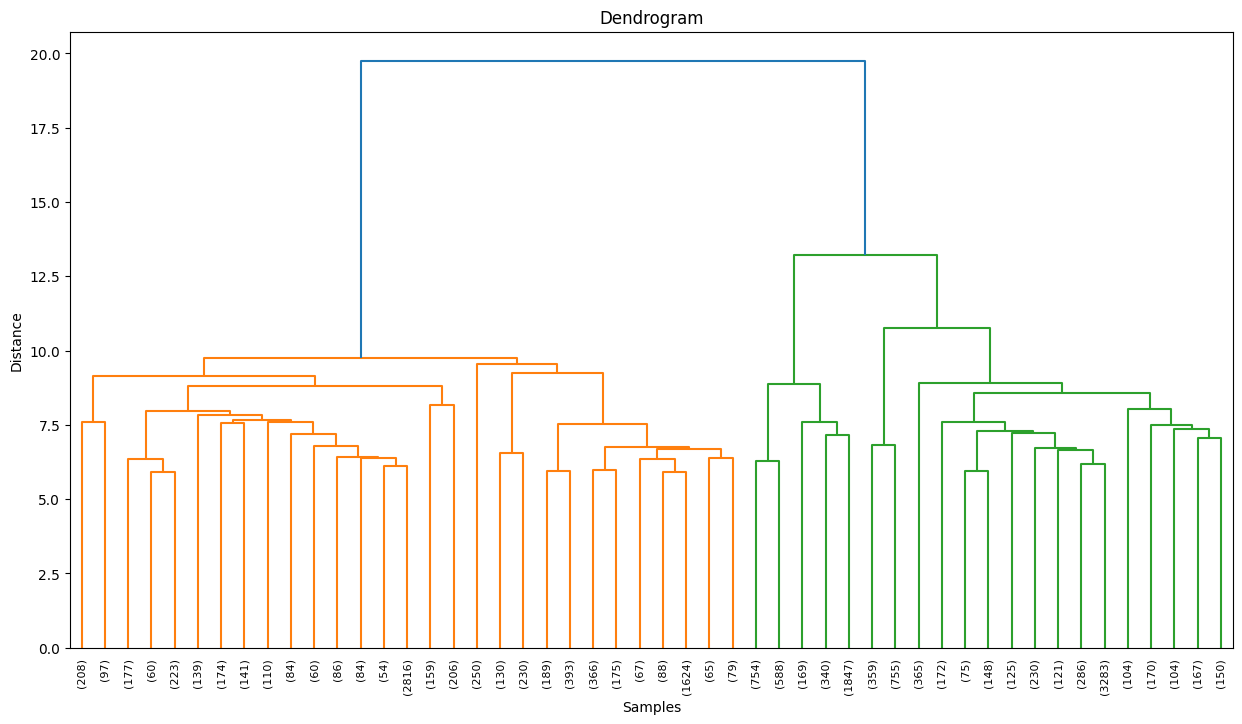

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Step 1: Converting text data into TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(newsgroups_data.data)

# Step 2: Applying Agglomerative Clustering
# Choose linkage method and distance metric (e.g., 'ward' and 'euclidean')
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward', metric='euclidean')

# Step 3: Plotting dendrogram to find the optimal number of clusters
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=50)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


Observations


---



As can be seen from the plot there are 2 optimal clusters by the dendogram diagram

Vertical Lines:  These lines represent merges between clusters. The length of the vertical line corresponds to the distance between the clusters being merged.

Longest Vertical Lines:These long lines indicate significant merges between clusters.

Horizontal Line Cuts: The number of times this line intersects with vertical lines represents the number of clusters.

Distance Threshold: Dendrograms are cut at a specific distance threshold. The max distance threshold based on our problem is 20

**Naive Bayes Classification**

In [8]:
from pyspark.sql import SparkSession
from sklearn.datasets import fetch_20newsgroups
from pyspark.ml.feature import CountVectorizer, IDF, StringIndexer, Tokenizer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MAX_MEMORY = "45g"

# Initialize a Spark session
session = SparkSession.builder \
    .appName("TextClusteringAndClassification") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()


# Fetch the 20 Newsgroups dataset and split into training and test sets
news_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Take a subset of the data
subset_size = 500  # Adjust the subset size as needed
news_train_subset = {
    'data': news_train.data[:subset_size],
    'target': news_train.target[:subset_size]
}

# Convert the subset data to Spark DataFrame
train_df = session.createDataFrame([(txt, float(lbl)) for txt, lbl in zip(news_train_subset['data'], news_train_subset['target'])], ["text", "label"])
test_df = session.createDataFrame([(txt, float(lbl)) for txt, lbl in zip(news_test.data, news_test.target)], ["text", "label"])

# Tokenize the text data
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

# Vectorize the tokens
count_vec = CountVectorizer(inputCol="tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# Convert labels to index
label_idx = StringIndexer(inputCol="label", outputCol="indexedLabel")

# K-means clustering
kmeans = KMeans(k=20, featuresCol="features", predictionCol="km_prediction")

# Hierarchical clustering (using Bisecting K-means in PySpark)
bisecting_kmeans = BisectingKMeans(k=20, featuresCol="features", predictionCol="bk_prediction")

# Naive Bayes classifie
naive_bayes = NaiveBayes(featuresCol="features", labelCol="indexedLabel", predictionCol="nb_prediction")

# Create pipelines
clustering_pipeline = Pipeline(stages=[tokenizer, count_vec, idf, kmeans, bisecting_kmeans])
classification_pipeline = Pipeline(stages=[tokenizer, count_vec, idf, label_idx, naive_bayes])

# Fit the models
clustering_model = clustering_pipeline.fit(train_df)
classification_model = classification_pipeline.fit(train_df)

# Make predictions
clustering_predictions = clustering_model.transform(test_df)
classification_predictions = classification_model.transform(test_df)

# Evaluate the Naive Bayes classifier
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="nb_prediction", metricName="accuracy")
accuracy = evaluator.evaluate(classification_predictions)
print(f"Naive Bayes Accuracy: {accuracy}")

# Show clustering results
clustering_predictions.select("text", "km_prediction", "bk_prediction").show(truncate=False)

# Stop the Spark session
session.stop()


Naive Bayes Accuracy: 0.36895910780669144
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Word 2 Vec Matrix**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Creating a SparkSession
spark = SparkSession.builder \
    .appName("20 Newsgroups Clustering") \
    .getOrCreate()

# Step 2: Loading and preprocessing the dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(data)

# Step 3: Pre-train Word2Vec embeddings
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="words", outputCol="word2vec")
model = word2vec.fit(wordsData)

# Step 4: Applying Word2Vec embeddings to your dataset
word2vecData = model.transform(wordsData)

# Step 5: Converting Word2Vec embeddings to numpy array
word2vec_matrix = np.array(word2vecData.select("word2vec").rdd.map(lambda x: x['word2vec']).collect())

# Printing the shape of the Word2Vec matrix
print("Word2Vec Matrix Shape:", word2vec_matrix.shape)

# Step 6: Stopping SparkSession
spark.stop()


Word2Vec Matrix Shape: (18846, 100)


In [ ]:
word2vec_matrix[0]

array([ 0.02127383,  0.02283398, -0.03200752, -0.01366151, -0.01836758,
        0.10008975, -0.02322527, -0.01272705,  0.03824782,  0.00205517,
       -0.01512119, -0.04400576, -0.17421363, -0.10282948, -0.09103091,
       -0.0699655 , -0.01547789,  0.04547207,  0.03931488,  0.05135369,
       -0.02213125, -0.03260632,  0.01918205, -0.03214232,  0.03923112,
        0.07455641, -0.01638517,  0.02894757, -0.08550331,  0.06834435,
        0.01476053,  0.00349607,  0.0040581 , -0.02413359, -0.07757481,
       -0.01586315, -0.06672394, -0.06382982,  0.03401444,  0.11874846,
       -0.05343922,  0.07816767,  0.00979153,  0.02010389,  0.0185683 ,
       -0.03168456, -0.00173072,  0.01696596, -0.02949219,  0.05711965,
        0.06707047,  0.01967141,  0.0118163 ,  0.02516125, -0.04385089,
        0.07729942,  0.04340721, -0.01157494,  0.07968605, -0.02900876,
       -0.04876734, -0.03428976,  0.01266048,  0.02162791,  0.02378243,
       -0.06215275, -0.03139231, -0.00064866, -0.02024151,  0.05

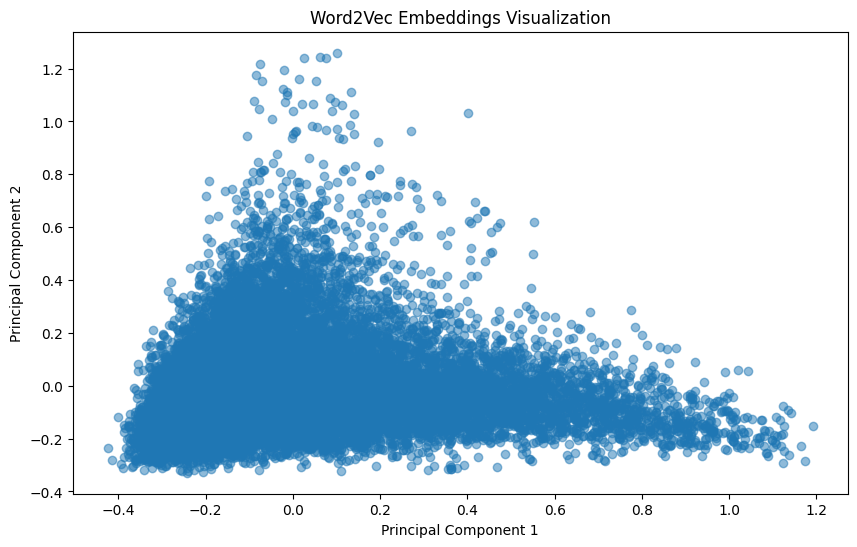

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word2vec_matrix)

# Step 7: Plotting the PCA-transformed Word2Vec embeddings
plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.5)
plt.title('Word2Vec Embeddings Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



**BERT Embeddings**

In [3]:
from pyspark.sql import SparkSession
from transformers import BertTokenizer, BertModel
import torch

# Step 1: Creating a SparkSession
spark = SparkSession.builder \
    .appName("20 Newsgroups BERT Embeddings") \
    .getOrCreate()

# Step 2: Loading and preprocessing the dataset
data = spark.createDataFrame([(text,) for text in newsgroups_data.data], ["text"])

# Step 3: Initializing BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Step 4: Defining a function to generate BERT embeddings for newsgroup data
def generate_bert_embeddings(text):
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy().tolist()

# Step 5: Applying the function to each document in the dataset
embeddings_df = data.rdd.map(lambda row: (row[0], generate_bert_embeddings(row[0]))).toDF(["text", "embeddings"])
print(embeddings_df)

# Step 7: Stopping SparkSession
spark.stop()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

DataFrame[text: string, embeddings: array<double>]


In [4]:
# The first few rows of the Bert Embedded DataFrame
embeddings_df.show()


+--------------------+--------------------+
|                text|          embeddings|
+--------------------+--------------------+
|From: Mamatha Dev...|[-0.1075833514332...|
|From: mblawson@mi...|[-0.0648567825555...|
|From: hilmi-er@ds...|[-0.0759366676211...|
|From: guyd@austin...|[-0.1551677882671...|
|From: Alexander S...|[-0.2101800143718...|
|From: tell@cs.unc...|[-0.2110511958599...|
|From: lpa8921@tam...|[0.16199521720409...|
|From: dchhabra@st...|[-0.0730527192354...|
|From: dchhabra@st...|[-0.0342849120497...|
|From: arromdee@jy...|[-0.0653017908334...|
|From: sandvik@new...|[0.03122873604297...|
|From: steve-b@acc...|[0.06521505862474...|
|From: Thyagi@cup....|[-0.0649897605180...|
|From: filipe@vxcr...|[-0.0572530366480...|
|From: kmr4@po.CWR...|[-0.0771965682506...|
|From: dbd@urartu....|[-0.1403309255838...|
|From: csulo@csv.w...|[0.05840203911066...|
|From: schmidt@auv...|[-0.0153778865933...|
|From: pmetzger@sn...|[-0.1007353812456...|
|From: mjs@sys.uea...|[-0.091328